# 一、实验背景
   用Sklearn实现新闻分类，在新闻类APP中，按照不同标签对新闻分类可以令读者更快速的查找到自己想要阅读的新闻。新闻分类数据集有C000008财经、C000010IT、C000013健康、C000014体育、C000016旅游、C000020教育、C000022招聘、C000023文化、C000024军事九类组成

# 二、实验总体设计
朴素贝叶斯算法（Naive Bayesian algorithm) 是应用最为广泛的分类算法之一。
朴素贝叶斯方法是在贝叶斯算法的基础上进行了相应的简化，即假定给定目标值时属性之间相互条件独立。朴素贝叶斯算法假设了数据集属性之间是相互独立的，因此算法的逻辑性十分简单，并且算法较为稳定，当数据呈现不同的特点时，朴素贝叶斯的分类性能不会有太大的差异。

本实验将分为这几个部分： (1)新闻中文语句切分  （2）文本特征选择  （3）使用Sklearn构建朴素贝叶斯分类器  （4）测试新闻分类准确度

# 三、实验详细设计与实现

## 导入实验所需工具包

In [1]:
import os
import random
import jieba
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

## 步骤一：定义函数功能

### 函数说明:中文文本处理
Parameters:

·folder_path - 文本存放的路径

·test_size - 测试集占比，默认占所有数据集的百分之20
    
Returns:

·all_words_list - 按词频降序排序的训练集列表

·train_data_list - 训练集列表

·test_data_list - 测试集列表

·train_class_list - 训练集标签列表

·test_class_list - 测试集标签列表

In [2]:
def TextProcessing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)  # 查看folder_path下的文件
    data_list = []  # 数据集数据
    class_list = []  # 数据集类别

    # 遍历每个子文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)  # 根据子文件夹，生成新的路径
        files = os.listdir(new_folder_path)  # 存放子文件夹下的txt文件的列表

        j = 1
        # 遍历每个txt文件
        for file in files:
            if j > 100:  # 每类txt样本数最多100个
                break
            with open(os.path.join(new_folder_path, file), 'r', encoding='utf-8') as f:  # 打开txt文件
                raw = f.read()

            word_cut = jieba.cut(raw, cut_all=False)  # 精简模式，返回一个可迭代的generator
            word_list = list(word_cut)  # generator转换为list

            data_list.append(word_list)  # 添加数据集数据
            class_list.append(folder)  # 添加数据集类别
            j += 1
    print(data_list)
    print(class_list)
    data_class_list = list(zip(data_list, class_list))  # zip压缩合并，将数据与标签对应压缩
    random.shuffle(data_class_list)  # 将data_class_list乱序
    index = int(len(data_class_list) * test_size) + 1  # 训练集和测试集切分的索引值
    train_list = data_class_list[index:]  # 训练集
    test_list = data_class_list[:index]  # 测试集
    train_data_list, train_class_list = zip(*train_list)  # 训练集解压缩
    test_data_list, test_class_list = zip(*test_list)  # 测试集解压缩

    all_words_dict = {}  # 统计训练集词频
    for word_list in train_data_list:
        for word in word_list:
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # 根据键的值倒序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f: f[1], reverse=True)
    all_words_list, all_words_nums = zip(*all_words_tuple_list)  # 解压缩
    all_words_list = list(all_words_list)  # 转换成列表
    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

### 函数说明:读取文件里的内容，并去重
Parameters:

·words_file - 文件路径

Returns:

·words_set - 读取的内容的set集合

In [3]:
def MakeWordsSet(words_file):
    words_set = set()  # 创建set集合
    with open(words_file, 'r', encoding='utf-8') as f:  # 打开文件
        for line in f.readlines():  # 一行一行读取
            word = line.strip()  # 去回车
            if len(word) > 0:  # 有文本，则添加到words_set中
                words_set.add(word)
    return words_set  # 返回处理结果

## 函数说明:文本特征选取
Parameters:

·all_words_list - 训练集所有文本列表

·deleteN - 删除词频最高的N个词

·stopwords_set - 指定的停顿词

Returns:

·feature_words - 特征集

In [4]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    feature_words = []  # 特征列表
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000:  # feature_words的维度为1000
            break
            # 如果这个词不是数字，并且不是指定的结束语，并且单词长度大于1小于5，那么这个词就可以作为特征词
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1 < len(all_words_list[t]) < 5:
            feature_words.append(all_words_list[t])
        n += 1
    return feature_words

## 函数说明:根据feature_words将文本向量化
Parameters:

·train_data_list - 训练集

·test_data_list - 测试集

·feature_words - 特征集

Returns:

·train_feature_list - 训练集向量化列表

·test_feature_list - 测试集向量化列表

In [5]:
def TextFeatures(train_data_list, test_data_list, feature_words):
    def text_features(text, feature_words):  # 出现在特征集中，则置1
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features

    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list  # 返回结果

### 函数说明:新闻分类器
Parameters:

·train_feature_list - 训练集向量化的特征文本

·test_feature_list - 测试集向量化的特征文本

·train_class_list - 训练集分类标签

·test_class_list - 测试集分类标签

Returns:

·test_accuracy - 分类器精度

In [6]:
def TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list):
    classifier = MultinomialNB().fit(train_feature_list, train_class_list)
    test_accuracy = classifier.score(test_feature_list, test_class_list)
    return test_accuracy

## 步骤二：文本预处理
顺利将每个文本进行切分，并进行了类别标记。

将所有文本分成训练集和测试集，并对训练集中的所有单词进行词频统计，并按降序排序。

In [7]:
folder_path = './SogouC/Sample'  # 训练集存放地址
all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path,test_size=0.2)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zhaogeng\AppData\Local\Temp\jieba.cache
Loading model cost 0.486 seconds.
Prefix dict has been built successfully.


[['\u3000', '\u3000', '本报记者', '陈雪频', '实习', '记者', '唐翔', '发自', '上海', '\n', '\u3000', '\u3000', '一家', '刚刚', '成立', '两年', '的', '网络', '支付', '公司', '，', '它', '的', '目标', '是', '成为', '市值', '100', '亿美元', '的', '上市公司', '。', '\n', '\u3000', '\u3000', '这家', '公司', '叫做', '快', '钱', '，', '说', '这句', '话', '的', '是', '快', '钱', '的', 'CEO', '关国光', '。', '他', '之前', '曾任', '网易', '的', '高级', '副总裁', '，', '负责', '过', '网易', '的', '上市', '工作', '。', '对于', '为什么', '选择', '第三方', '支付', '作为', '创业', '方向', '，', '他', '曾经', '对', '媒体', '这样', '说', '：', '“', '我能', '看到', '这个', '胡同', '对面', '是', '什么', '，', '别人', '只能', '看到', '这个', '胡同', '。', '”', '自信', '与', '狂妄', '只有', '一步之遥', '—', '—', '这', '几乎', '是', '所有', '创业者', '的', '共同', '特征', '，', '是', '自信', '还是', '狂妄', '也许', '需要', '留待', '时间', '来', '考证', '。', '\n', '\u3000', '\u3000', '对于', '市值', '100', '亿美元', '的', '上市公司', '，', '他', '是', '这样', '算', '这笔', '账', '的', '，', '“', '百度', '上市', '时', '广告', '客户', '数量', '只有', '4', '万', ',', '而且', '它', '所', '做', '的', '只是', '把', '客户', '吸引', '过来', '，', '就', '可以', '支撑

In [8]:
print(all_words_list) #将所有训练集的切分结果通过词频降序排列构成的单词合集。

['，', '的', '\u3000', '。', '\n', ';', '&', 'nbsp', ' ', '在', '、', '了', '是', '“', '”', '和', '：', '\x00', '有', '也', '就', '中国', '我', '上', '公司', '对', '为', '将', '都', '年', '要', '中', '他', '与', '而', '月', '—', '游客', '不', '这', '可以', '你', '考生', '人', '日', '一个', '到', '3', '（', '）', '但', '自己', '等', '(', ')', '；', '时', '旅游', '说', '市场', '1', '个', '多', '进行', '5', '还', '会', '.', '没有', '时间', '从', '把', '让', '志愿', '来', '％', '企业', '北京', '已经', '后', '美国', '被', '地', '以', '更', '我们', '小', '做', '很', '目前', '新', '工作', '支付', '并', '药', '2', '[', ']', '０', '4', '给', '大家', '仿制', '复习', '主要', '9', '这样', '《', '》', '很多', '成为', '他们', '…', '下', '学校', '能', '可能', '如果', '发展', '问题', '上海', '袁', '五一', '黄金周', '10', '一定', '大', '选择', '品牌', '又', '基础', '时候', '银行', '部分', '2005', '一些', '看', '使', '向', '通过', '认为', '去', '亿美元', ',', '该', '可', '因为', '就是', '用', '6', '词汇', '辅导班', '记者', '着', '家', '电话', '考试', '快', '钱', '由', '增长', '表示', '这个', '建设', '比较', '２', '毕业生', '其', '则', '重要', '接待', '万人次', '收入', '其中', '期间', '过', '专业', '能力', '．', '最', '填报', '0'

## 步骤三：测试新闻分类准确性

In [9]:
stopwords_file = './stopwords_cn.txt'
stopwords_set = MakeWordsSet(stopwords_file)

In [10]:
test_accuracy_list = []

deleteNs = range(0, 1000, 20)  # 0 20 40 60 ... 980
for deleteN in deleteNs:
    feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
    test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
    test_accuracy_list.append(test_accuracy)

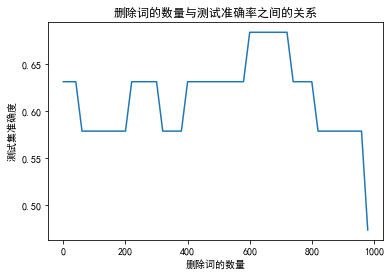

In [11]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('删除词的数量与测试准确率之间的关系')  #删除词的数量与测试准确率之间的关系
plt.xlabel('删除词的数量')
plt.ylabel('测试集准确度')
plt.show()

In [12]:
feature_words = words_dict(all_words_list, 450, stopwords_set)
train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)
test_accuracy = TextClassifier(train_feature_list, test_feature_list, train_class_list, test_class_list)
test_accuracy_list.append(test_accuracy)
print(feature_words)
ave = lambda c: sum(c) / len(c)
print(ave(test_accuracy_list))

['一年', '条件', '得到', '技术', '院校', '组织', '获得', '帮助', '往往', '业务', '上市', '数字', '小时', '概念', '能够', '方法', '患者', '完成', '面对', '备考', '王治郅', '埃及', '信息', '万元', '超过', '休闲', '完全', '每个', '过程', '原因', '领域', '领导', '经验', '这次', '第一', '稳定', '客户', '中心', '感觉', '简历', '代表', '相当', '事情', '不要', '客场', '思路', '国际', '媒体', '免息', '第一次', '上午', '电子', '昨天', '赔偿', '制药', '图库', '数量', '更加', '其实', '演练', '这一', '利用', '之后', '不断', '一场', '未来', '过去', '开通', '不少', '成功', '职业', '努力', '支持', '最近', '欧洲', '学生', '提前', '感到', '公布', '分公司', '很快', '面试', '一样', '建立', '著名', '关国光', '特点', '应用', '回家', '过年', '疼痛', '南京', '每天', '去年同期', '市民', '越来越', '专家', '加强', '结果', '综合', '一起', '参与', '工程', '很大', '方向', '社会', '晋升', '根本', '同事', '喜欢', '价值', '每股', '网站', '一般', '女士', '三个', '同学', '广告', '题型', '练习', '运动', '作用', '最好', '失眠', '因素', '振保', '韩国', '泰国', '标志', '消费', '解题', '公式', '电视', '本科', '标题', '元老', '顾客', '密码', '批次', '价格', '医药', '单位', '结束', '旅游者', '亿元', '联想', '报道', '新型', '发挥', '展开', '发出', '办法', '人士', '资源', '十分', '发生', '起来', '总部', '举办', '取得', '研究', '指挥', '水平', '投入', '保证', '